# Behavioral Profile Stratification via Unsupervised learning

### TODO

> Please report some description here about the pipeline and what I am going to find in the notebook

## Step 1: Data Loading

> Short description here - and notes on Data Accessibility

In [28]:
from dataset import access_db, data_wrangling, cohort_info

In [29]:
# it returns a dictionary of pandas dataframes storing tables from the db
tables = access_db()

In [30]:
# reduced dictionary (it excludes tables and subjects taht are not required, e.g., ados-2modulo4, eas)
rid_tables = data_wrangling(tables)

In [31]:
# it returns dictionary of subjects info and encounters
pinfo, penc = cohort_info(rid_tables)

## Step 2: Feature Processing

> Short description here

In [32]:
from features import DataFeatures

In [33]:
datafeatures = DataFeatures(level=3, df_dict=rid_tables)

In [34]:
behr, (bt_to_idx, idx_to_bt) = datafeatures.create_level_tokens()

---

## Step 3: Embeddings

> Short description here

In [35]:
from pt_embedding import Pembeddings

In [36]:
model = Pembeddings(behr, bt_to_idx)

In [37]:
svd_pid_list, svd_mtx = model.tfidf()

Performing SVD on the TF-IDF matrix...


In [38]:
glove_pid_list, glove_emb, word_emb = model.glove_pemb()


Training Glove embeddings...
epoch 0, error 0.008
epoch 10, error 0.007
epoch 20, error 0.006
epoch 30, error 0.006
epoch 40, error 0.005


---

## Step 4: Clustering

> Short description here

In [39]:
from clustering import HclustEmbeddings, HclustFeatures
import utils as ut

In [40]:
hclust_emb = HclustEmbeddings(min_cl=ut.min_cl, max_cl=ut.max_cl, 
                              affinity='euclidean', linkage='ward')

### `TF-IDF` Embedding

In [41]:
# TFIDF EMBEDDING
# tfidf_best_cl = hclust_emb.find_best_nclu(svd_mtx, n_iter=ut.n_iter, 
#                                           subsampl=ut.subsampl)
tfidf_best_cl = hclust_emb.elbow_method(svd_mtx)

In [42]:
tfidf_subc = hclust_emb.fit(svd_mtx, svd_pid_list, tfidf_best_cl)

(*) Number of clusters 4 -- Silhouette score 0.19
Cluster 0 -- Numerosity 41
Cluster 1 -- Numerosity 72
Cluster 2 -- Numerosity 46
Cluster 3 -- Numerosity 46






### `Glove` Embedding

In [43]:
# GLOVE EMBEDDING
# glv_best_cl = hclust_emb.find_best_nclu(glove_emb, n_iter=ut.n_iter, subsampl=ut.subsampl)
glv_best_cl = hclust_emb.elbow_method(glove_emb)

In [44]:
glv_subc = hclust_emb.fit(glove_emb, glove_pid_list, glv_best_cl)

(*) Number of clusters 2 -- Silhouette score 0.26
Cluster 0 -- Numerosity 142
Cluster 1 -- Numerosity 63






## Step 5: Clustering II (Visualization) 

> Short description here

In [45]:
from visualization import Visualization

In [46]:
viz = Visualization(pinfo, ut.col_dict, ut.c_out)

In [47]:
# Example of visualization for tfidf embeddings
# Prepare data for umap and dendrogram
umap_mtx, pid_subc_list = viz.data_scatter_dendrogram(svd_mtx, tfidf_subc, svd_pid_list, random_state=42,
                                                      n_neighbors = 100,
                                                      min_dist=0.0)

Loading BokehJS ...

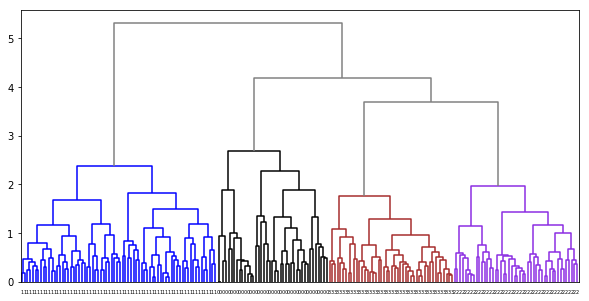

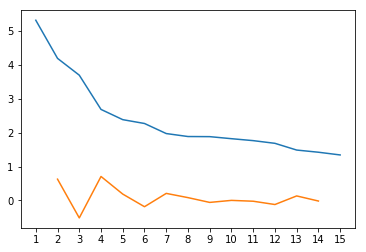

In [48]:
viz.scatterplot_dendrogram(svd_mtx, umap_mtx, pid_subc_list, 10, 5)

In [49]:
# Prepare data for heatmap
emb_scaled = viz.data_heatmap_emb(behr, bt_to_idx, tfidf_subc)

In [50]:
viz.heatmap_emb(emb_scaled, 400, 1000)

In [51]:
# Example of visualization for GloVe embeddings
# Prepare data for umap and dendrogram
umap_mtx, pid_subc_list = viz.data_scatter_dendrogram(glove_emb, glv_subc, glove_pid_list, random_state=42,
                                                      n_neighbors = 100,
                                                      min_dist=0.0)

Loading BokehJS ...

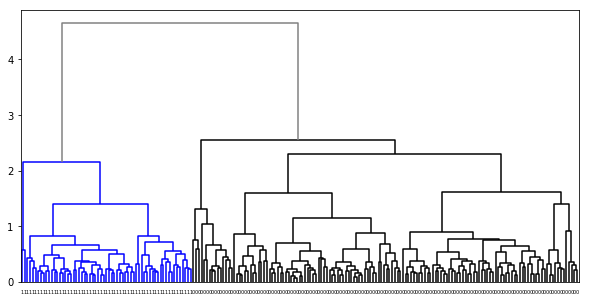

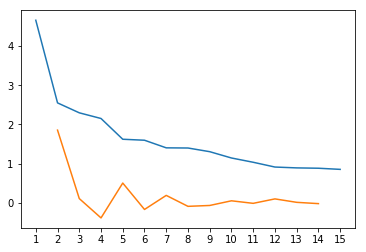

In [52]:
viz.scatterplot_dendrogram(glove_emb, umap_mtx, pid_subc_list, 10, 5)

In [53]:
# Prepare data for heatmap
emb_scaled = viz.data_heatmap_emb(behr, bt_to_idx, glv_subc)

In [55]:
viz.heatmap_emb(emb_scaled, 500, 800)